## Tank Puzzle
You have probably seen puzzles like this on your social feed. The point is usually to notice some of the pipes are blocked (tanks D and H), but that ignores the engineering fact that it takes time for water to flow through the pipes and equalize. Let's get a better solution and learn how to handle a non-linear system of differential equations at the same time.

<img src='Tank Puzzle.png'>

Laminar flow rate $Q$ in a tube depends on the elevation difference $H$ and the friction in the tube which is proportional to length $L$ of the tube and viscosity $\nu$ of the liquid

\begin{equation}
Q = \frac{\pi g}{128 \nu}\frac{L}{D^4}H
\end{equation}

if we ignore the forces that go into accelerating the fluid. It gets more complicated if we add that in, and considerably more complicated if we account for the possibility turbulent flow. 

Let's build that into a function and try it for a basic case like a 1 cm tube.

In [1]:
%matplotlib inline
from numpy import *                # numerical library
import matplotlib.pyplot as plt

In [2]:
def Q(H,L,D):
    # From Fluid Mechanics for an elevation difference H, pipe length L and Diameter D
    # flow rate Q depends on flow regime and other factors. Here we will assume a simple 
    # laminar flow in a smooth tube and ignore all forces except friction.
    nu = 1e-6                 # the kinematic viscosity of water
    g = 9.806                 # acceleration due to gravity
    Q = pi * g / (128 * nu) * D**4/L * H    
    return Q
    
Q(1,1,.01)

0.0024067544969610557

Do a reasonableness check on the numbers, noting that 0.00033 m^3/s is 1/3 of a litre per second, about one beverage can. That flow seems too high to me! We need to account for the elevation change accelerating the fluid. Even if there was no friction, the flow velocity will be limited by conservation of energy following Bernoulli's equation.

This next function is ugly with a whole lot of things that could be improved with better numerics (which you'll get in your math courses), but it is great to illustrate the point of how to cope with a process based function Q() that isn't readily written as an explicit formula!

In [5]:
def Q(H,L,D):
    # From Fluid Mechanics for an elevation difference H, pipe length L and Diameter D
    # flow rate Q depends on flow regime and other factors. Here we will assume a simple 
    # laminar flow in a smooth tube and ignore the entry and exit losses and iterate 
    # towards a solution that balances the friction, gravity and dynamics.
    if(abs(H)<0.001): return 0
    sign = 1                  # for negative H calculate positive, then reverse at the end
    if(H < 0):                # otherwise the sqrt() will cause problems
        H *= -1
        sign *= -1
    nu = 1e-6                 # the kinematic viscosity of water
    g = 9.806                 # acceleration due to gravity
    V = sqrt(2*g*H)           # ignore friction on the first guess
    delta = 1                 # a change measure
    n = 0                     # iterations
    while(delta > 0.0001 and n < 1000):     # improve the estimate
        # What elevation would be required to overcome friction
        delta = V
        Hf = 32 * nu / g * L / D**2 * V
        # move slowly towards the right answer to avoid numerical instability 
        # around 0 (0.1 instead of 1)
        Ha = max(H - 0.1 * Hf,H/1000)
        #print(V,Hf)           # watch convergence, but comment out for use
        V = sqrt(2*g*Ha)
        delta = abs((delta-V)/(delta+0.00000000001))
        n += 1
    Q = pi * D**2 / 4 * V      # flow rate is velocity times cross sectional area
    return sign * Q
    
Q(-1,15,.01)

-0.00031215407719007414

Do a reasonableness check on the numbers, noting that 0.00033 m^3/s is 1/3 of a litre per second, about one beverage can. Test it over a range of values.

Text(0,0.5,'Flow [litres/s]')

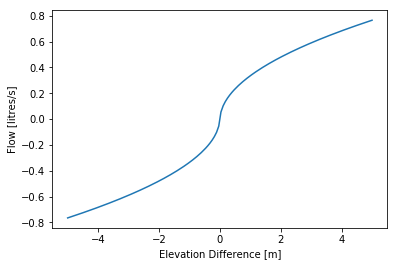

In [6]:
n = 140
h = linspace(-5,5,n)
q = h.copy()
for i in range(0,n): q[i] = Q(h[i],5,.01)
plt.plot(h,q*1000)
plt.xlabel('Elevation Difference [m]')
plt.ylabel('Flow [litres/s]')

This relationship is complicated, but we have a process to calculate it for any set of conditions so we can move on to look at its effects.

# Flow Transient 
## User Euler's Method to predict transient level changes

A balance on tank A tells us that the volume in tank A will increase or decrease based on the difference between the flow coming in from the tap and the flow going out from the tube to tank B: 

\begin{equation}
    \frac{dV_a}{dt} = Q_t - Q_{ab}
\end{equation}

and the volume depends on the height and the area, so

\begin{equation}
    \frac{dH_a}{dt} = \frac{Q_t - Q_{ab}}{Aa}
\end{equation}

So we need to be able to calculate flow from A to B for different cases:
* Ha and Hb are both below the tube and there is no flow
* Ha is above the tube but Hb is below, so flow depends only on Ha
* Hb is above the tube but Ha is below, so flow depends only on Hb
* Ha and Hb are both above the tube, so flow depends on the difference Ha - Hb

Assume the bottom of tank A is at 3 m and the tube is at 3.1 m. while the bottom of tank B is at 2.5 m. Ignore tank C and it's tube for now.

Calculate all the flow rates at the current time step, then advance the tank levels using Euler's Method for each of the tanks.

If the flow from the tap is fixed, then sometimes it will be larger than the outflow, maybe even all the time if we set it quite high.

\begin{equation}
    H_a(t+\Delta t) = H_a(t) + \frac{dH_a}{dt}\Delta t = H_a(t) + \frac{Q_t - Q_{ab}}{Aa}\Delta t
\end{equation}

As long as you have a differential equation for each of the elements (tanks) you can solve for as many different interacting elements as you want! 

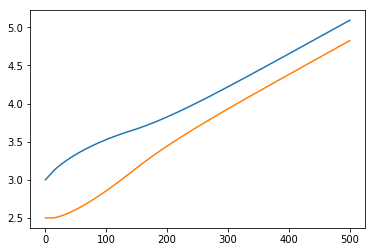

In [7]:
Qtap = 0.000354    # one beverage can per second
n = 500            # number of time steps
dt = 1             # length of a time step
t = linspace(0,n*dt,n)
Ha = zeros(n)
Ha[0] = 3.0        # the bottom of the tank
Hb = zeros(n)    
Hb[0] = 2.5
Qab = zeros(n)
Qt = Qtap + zeros(n)      # 1 beverage can per second
A = 0.04           # 20 cm by 20 cm, the same for all the tanks
D = 0.01           # 1 cm, the same for all the tubes
L = 1              # 1 m, the same for all the tubes
for i in range(0,n-1):
    # fill in the blanks, then calculate the new values of H
    #check all four cases for Qab
    if(Ha[i] < 3.1):
        if(Hb[i] < 3.1): Qab[i] = 0                 # both lower than tube
        else: Qab[i] = Q(3.1-Hb[i],L,D)             # A lower, B higher
    else:
        if(Hb[i] < 3.1): Qab[i] = Q(Ha[i]-3.1,L,D)  # A higher, B lower
        else: Qab[i] = Q(Ha[i]-Hb[i],L,D)           # both higher then tube
            
    Ha[i+1] = Ha[i] + (Qt[i] - Qab[i])/A * dt
    Hb[i+1] = Hb[i] + (Qab[i])/A * dt
plt.plot(t,Ha,label='Tank A')
plt.plot(t,Hb,label='Tank B')


So Tank A starts filling and when it gets up to the tube it fills more slowly because some of the flow goes through the tube and starts filling tank B. Then both keep on rising forever, so we need to account for overflowing edges, and we'll add tank C at the same time.

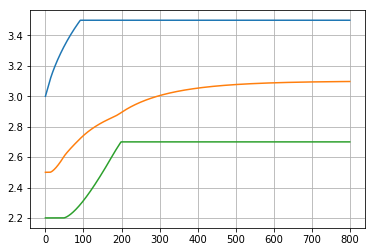

In [8]:
n = 800           # number of time steps
dt = 1             # length of a time step
A = 0.04           # 20 cm by 20 cm, the same for all the tanks
D = 0.01           # 1 cm, the same for all the tubes
L = 1              # 1 m, the same for all the tubes
def CalcPlot():
    Qt = Qtap + zeros(n)      # 1 beverage can per second
    t = linspace(0,n*dt,n)
    Ha = zeros(n)
    Ha[0] = 3.0        # the bottom of the tank
    Hb = zeros(n)    
    Hb[0] = 2.5
    Qab = zeros(n)
    Hc = zeros(n)    
    Hc[0] = 2.2
    Qbc = zeros(n)
    for i in range(0,n-1):
        # fill in the blanks, then calculate the new values of H
        if(Ha[i] < 3.1):
            if(Hb[i] < 3.1): Qab[i] = 0                 # both lower than tube
            else: Qab[i] = Q(3.1-Hb[i],L,D)             # A lower, B higher
        else:
            if(Hb[i] < 3.1): Qab[i] = Q(Ha[i]-3.1,L,D)  # A higher, B lower
            else: Qab[i] = Q(Ha[i]-Hb[i],L,D)           # both higher then tube

        if(Hb[i] < 2.6):
            if(Hc[i] < 2.6): Qbc[i] = 0                 # both lower than tube
            else: Qbc[i] = Q(2.6-Hc[i],L,D)             # A lower, B higher
        else:
            if(Hc[i] < 2.6): Qbc[i] = Q(Hb[i]-2.6,L,D)  # A higher, B lower
            else: Qbc[i] = Q(Hb[i]-Hc[i],L,D)           # both higher then tube

        Ha[i+1] = min(Ha[i] + (Qt[i] - Qab[i]) / A * dt,3.5)
        Hb[i+1] = min(Hb[i] + (Qab[i] - Qbc[i]) / A * dt,3.2) 
        Hc[i+1] = min(Hc[i] + (Qbc[i])/A * dt,2.7) 
    plt.plot(t,Ha,label='Tank A')
    plt.plot(t,Hb,label='Tank B')
    plt.plot(t,Hc,label='Tank C')
    plt.grid()
CalcPlot()

Tank A starts filling, then overflows into tank B through the tube and eventually overflows the top of the tank, so in this case tank A fills first! Tank B never gets full! Experiemnt with changing the flow to see the effects, and extend the model to all the interesting tanks (C, J, L, F, maybe even I and K). What is the effect of changing the time step size? 

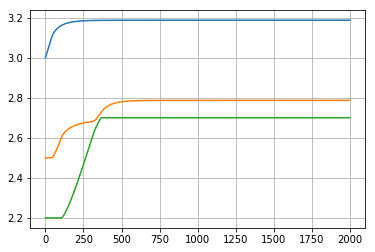

In [9]:
Qtap = 0.0001
n=2000
dt =1
CalcPlot()